# OpenDSSDirect: Feeder Analysis and Solar Integration
OpenDSSDirect provides an interface for building, running, and analyzing circuits in OpenDSS. It is a means fo "driving" OpenDSS from outside of the command line interface we have already learned. It allows the user to develop their own functionalities that may not be included in the standard OpenDSS program and tailor analysis to their research needs. 

### Installation
First we need to install OpenDSSDirect.py in our current python environment. Activate the desired environment and run the following command in a terminal:

<font color='orange'> pip install OpenDSSDirect.py[extras] </font>

Create an instance of OpenDSS in Python and interface to the command line interface in OpenDSS. We can create a shorthand for the <font color='orange'> dss.utils.run_command </font> as <font color='orange'> cmd </font>. This will be our interface for all commands we wish to run in OpenDSS. 

In [36]:
import opendssdirect as dss
import matplotlib.pyplot as plt
import numpy as np

cmd = dss.utils.run_command

We can now use <font color='orange'> cmd </font> to run the same commands we previously typed directly into the OpenDSS script editor. To <font color='orange'> clear </font> the OpenDSS registers as one should at the beginning of each model, simply type the following command.  

In [37]:
cmd('clear')

''

Use a <font color='orange'> reply </font> variableas shown below to to access any error messages raised by OpenDSS. Watch what happens below if I try to solve a circuit that is not defined. 

In [38]:
reply1=cmd('clear')
print('reply1:',reply1)

reply2=cmd('solve')
print('reply2:',reply2)

reply1: 
reply2: You must create a new circuit object first: "new circuit.mycktname" to execute this command.


### Building a model line-by-line or use redirect
We can build a load flow model in OpenDSS direct by typing out each line of the code, using <font color='orange'> cmd </font> from above. Or we can use the <font color='orange'> Redirect </font> command as shown below. This command will redirect the command interpreter to take input directly from a text file. Once it reaches the end of the text file it will return to the original script from which it was called. 

In [39]:
# manually type out each line if we are building a new model
reply=cmd('clear')
reply1=cmd('set DefaultBaseFrequency=50')
reply2=cmd('set datapath=C:\\Users\\epohl\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\inputs_outputs_snapshot')
reply3=cmd('new circuit.simple_example_snapshot basekv=132 pu=1.0 angle=0 frequency=50 phases=3')
#etc....
reply4=cmd('solve')
print(reply, reply1, reply2, reply3, reply4)

In [40]:
#use redirect command and the directory location of our previously built model.
cmd('clear')
reply=cmd('redirect C:\\Users\\epohl\\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\Simple_example_snapshot.dss')
print(reply)

### Retrieving Results from out snapshot model
Let's start with some simple numbers. Print out total power, loads, bus voltages, and line loadings and plot our voltage profile 

Total power delivered to circuit:
	 7209.044767185278 kw 3871.8623762176635 kvar

2  loads on this feeder:
	 Name = primary_load1, kW = 6750.0, kvar = 3269.0
	 Name = secondary_load1, kW = 315.0, kvar = 153.0

6 buses in this feeder:
	 Name = sourcebus, voltage = [75999.54529687471, 75999.54529687602, 75999.54529688018]
	 Name = a, voltage = [18695.80835890892, 18695.808358909555, 18695.808358910508]
	 Name = b, voltage = [18029.800717460494, 18029.800717461298, 18029.800717462764]
	 Name = c, voltage = [18006.607996145147, 18006.607996146053, 18006.60799614772]
	 Name = d, voltage = [216.76114140623787, 216.76114140626413, 216.76114140629142]
	 Name = e, voltage = [208.76999100769564, 208.76999100732945, 208.7699910054486]

3 lines in this feeder:
	 Name = linea-b, normamps = 220.0, line loading = [143.5621906720171, 143.562190672008, 143.56219067195622]
	 Name = lineb-c, normamps = 165.0, line loading = [6.078000062251334, 6.07800006223659, 6.078000062175591]
	 Name = lined-e, normam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


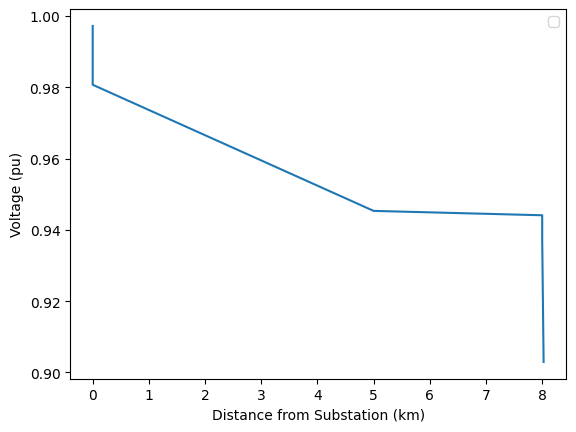

In [41]:
#basic numbers
print("Total power delivered to circuit:\n\t", dss.Circuit.TotalPower()[0]*-1,'kw',dss.Circuit.TotalPower()[1]*-1,'kvar')
print('\n'+str(dss.Loads.Count())," loads on this feeder:")
dss.Loads.First()
while True:
    print('\t Name = {name}, kW = {kW}, kvar = {kvar}'.format(name=dss.Loads.Name(),kW=dss.Loads.kW(), kvar=dss.Loads.kvar()))
    if not dss.Loads.Next() > 0:
        break

voltage_pu=[]
distance=[]
print('\n'+str(dss.Circuit.NumBuses()), "buses in this feeder:")
for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    print('\t Name = {bus_name}, voltage = {voltage}'.format(
        bus_name=dss.Bus.Name(), 
        voltage=[dss.Bus.VMagAngle()[0], dss.Bus.VMagAngle()[2], dss.Bus.VMagAngle()[4]]))
    distance.append(dss.Bus.Distance())
    voltage_pu.append(dss.Bus.PuVoltage()[0])

print('\n'+str(dss.Lines.Count()), 'lines in this feeder:')
dss.Lines.First()
while True:
    print('\t Name = {name}, normamps = {normamps}, line loading = {line_loading}'.format(
        name=dss.Lines.Name(),
        normamps=dss.Lines.NormAmps(), 
        line_loading=[dss.CktElement.CurrentsMagAng()[0],dss.CktElement.CurrentsMagAng()[2], dss.CktElement.CurrentsMagAng()[4]]
        ))
    if not dss.Lines.Next() > 0:
        break

fig, ax=plt.subplots()
ax.plot(distance,voltage_pu)
ax.set_xlabel('Distance from Substation (km)')
ax.set_ylabel('Voltage (pu)')
ax.legend();

### Timeseries Analysis
Let's redirect to our timeseries model. To perform timeseries analyses we can iterate through each timestep and save metrics to plot. Let's plot out loadshape and P and Q at the substation. 

In [42]:
cmd('clear')
reply=cmd('redirect C:\\Users\\epohl\\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\Simple_example_timeseries.dss')
print(reply)

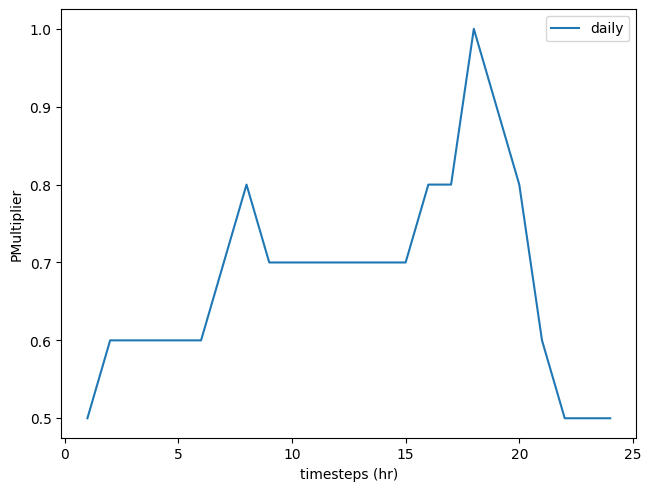

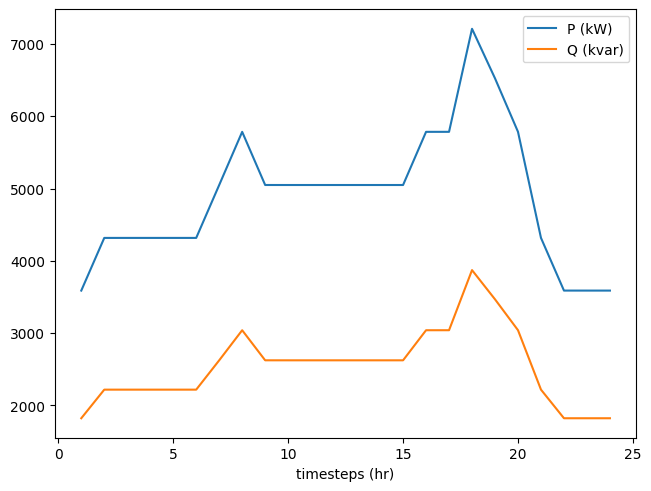

In [43]:
dss.LoadShape.Name('daily')
timesteps=range(1,dss.LoadShape.Npts()+1)
pmultiplier=dss.LoadShape.PMult()

kw=[]
kvar=[]
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve() # the advancing happens here
    kw.append(-dss.Circuit.TotalPower()[0])
    kvar.append(-dss.Circuit.TotalPower()[1])

fig, ax=plt.subplots(layout='constrained')
ax.plot(timesteps,pmultiplier, label=dss.LoadShape.Name())
ax.set_xlabel('timesteps (hr)')
ax.set_ylabel('PMultiplier')
ax.legend();

fig, ax=plt.subplots(layout='constrained')
ax.plot(timesteps,kw, label='P (kW)')
ax.plot(timesteps,kvar, label='Q (kvar)')
ax.set_xlabel('timesteps (hr)')
ax.legend();

#### Timeseries Voltage Analysis
It may be helpful to see the range of voltages at each bus over the time frame being modeled. Let's plot a box and whisker plot to visualize this. 

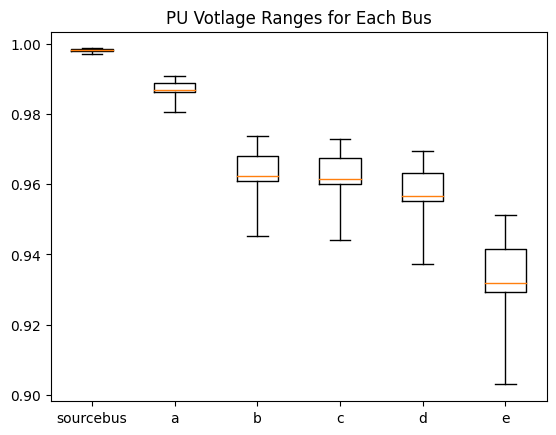

In [44]:
voltage_ts={}

for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    voltage_ts[bus]=[]
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()
        voltage_ts[bus].append(dss.Bus.PuVoltage()[0])

fig1,ax1=plt.subplots()
ax1.set_title('PU Votlage Ranges for Each Bus')
ax1.boxplot([v for v in voltage_ts.values()], labels= voltage_ts.keys(), whis=[0,100]);



#### Timeseries Loading Analysis
Likewise, it may be useful to the max load of each conductor over our time series as a percent of their normal ampacity rating. One can uncomment the first two lines to add another large load to busC and overload a line. Then let's print out all of the linesegments that are overloaded in this scenario. 


In [45]:
# reply=cmd('new load.primary_load2 bus1=C phases=3 kv=33 kw=5400 kvar=2615 model=1 daily=daily status=variable') #6000kVA at pf=0.90
# print('reply:', reply)

print('Timeseries Line Loadings:')

dss.Lines.First()
overloads=[]
while True:
    maxload=False
    normamps=dss.Lines.NormAmps()
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()
        timestep_load=max(dss.CktElement.CurrentsMagAng()[0],dss.CktElement.CurrentsMagAng()[2], dss.CktElement.CurrentsMagAng()[4])
        if not maxload:
            maxload=timestep_load
        elif timestep_load>maxload:
            maxload=timestep_load
    if maxload>normamps:
        overloads.append(dss.Lines.Name())
    print('Name = {name},\t Max line loading = {max_amps} A, \t Max line loading percent = {maxload_pct} %'.format(
        name=dss.Lines.Name(),max_amps=maxload, maxload_pct=100*maxload/normamps
        ))
    if not dss.Lines.Next() > 0:
        break

print('\nOverloaded line segments:')
for line in overloads:
    print(line)

reply: 
Timeseries Line Loadings:
Name = linea-b,	 Max line loading = 239.58407743276982 A, 	 Max line loading percent = 108.90185337853173 %
Name = lineb-c,	 Max line loading = 108.10035356332995 A, 	 Max line loading percent = 65.51536579595755 %
Name = lined-e,	 Max line loading = 469.47382127523014 A, 	 Max line loading percent = 81.64762109134438 %

Overloaded line segments:
linea-b


#### Timeseries Loss Assessment
One can also look at the losses over each timestep in our simulation. This can be useful if we want to monetize our loss metrics and visualize lost revenue. The plots below show losses at each timestep, cumulative losses over our simulation timeframe, and cumulative lost revenue over the simulation timeframe. 

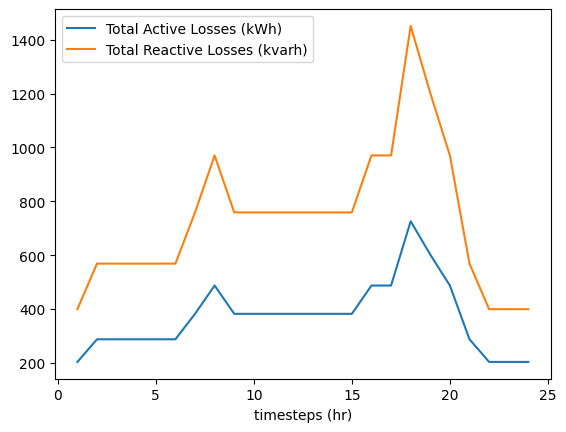

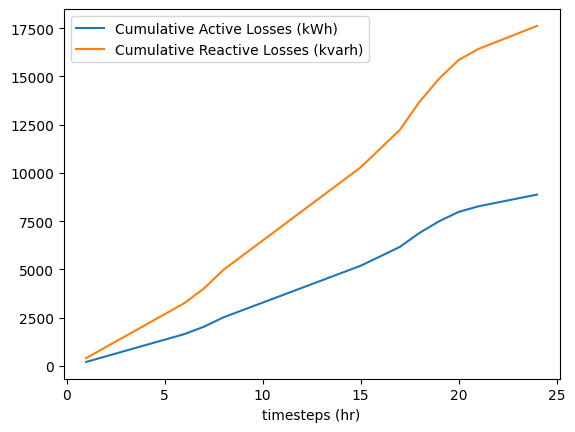

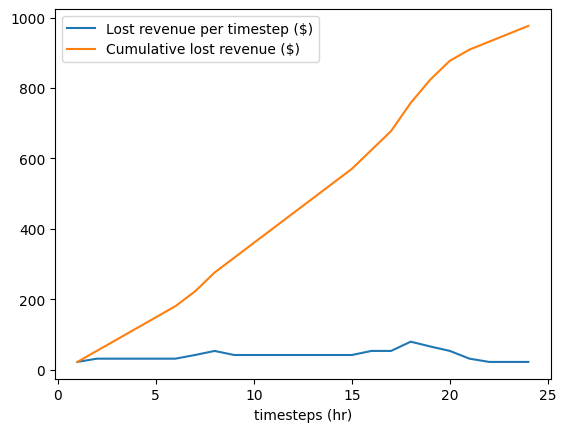

In [46]:
import numpy as np

active_losses=[]
reactive_losses=[]
timesteps=range(1,dss.LoadShape.Npts()+1)
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve()
    active_losses.append(dss.Circuit.Losses()[0]/1000)
    reactive_losses.append(dss.Circuit.Losses()[1]/1000)

cumulative_active_losses=np.cumsum(np.asarray(active_losses))
cumulative_reactive_losses=np.cumsum(np.asarray(reactive_losses))

price_kwh=0.11
lost_revenue=np.asarray(active_losses)*price_kwh
cumulative_lost_revenue=np.cumsum(lost_revenue)

fig,ax=plt.subplots()
ax.plot(timesteps, active_losses, label='Total Active Losses (kWh)')
ax.plot(timesteps, reactive_losses, label='Total Reactive Losses (kvarh)');
ax.set_xlabel('timesteps (hr)')
ax.legend();

fig,ax=plt.subplots()
ax.plot(timesteps, cumulative_active_losses, label='Cumulative Active Losses (kWh)')
ax.plot(timesteps, cumulative_reactive_losses, label='Cumulative Reactive Losses (kvarh)')
ax.set_xlabel('timesteps (hr)')
ax.legend();

fig1,ax1=plt.subplots()
ax1.plot(timesteps, lost_revenue, label='Lost revenue per timestep ($)')
ax1.plot(timesteps, cumulative_lost_revenue, label='Cumulative lost revenue ($)')
ax1.set_xlabel('timesteps (hr)')
ax1.legend();

#### Distributed Generation.
Let us now add our solar system as shown in the oneline from yesterday's tutorial. This can be done with the commands below. Note we are using a different loadshape that mimics irradiance data for our timeframe!<br>
<br>
<img src="Oneline.jpg">

In [47]:
cmd('clear')
reply=cmd('redirect C:\\Users\\epohl\\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\Simple_example_timeseries.dss')
print(reply)

reply1=cmd('new loadshape.solar_daily npts=24 interval=1.0 csvfile=C:\\Users\\epohl\\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\inputs_outputs_timeseries\\solar_daily.txt')
reply2=cmd('new pvsystem.pv1 bus1=C phases=3 kv=33 kva=3000 irradiance=0.98 pmpp=3000 kvar=0 %cutin=0.05 %cutout=0.05 daily=solar_daily')
print(reply1, reply2)

# reply1=cmd('new loadshape.solar_daily npts=24 interval=1.0 csvfile=C:\\Users\\epohl\\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\inputs_outputs_timeseries\\solar_daily.txt')
# reply2=cmd('new pvsystem.pv1 bus1=C phases=3 kv=33 kva=10000 irradiance=0.98 pmpp=10000 kvar=0 %cutin=0.05 %cutout=0.05 daily=solar_daily')
# print(reply1, reply2)

#### PV Voltage Analysis
Let's look at how our solar system affects the feeder's voltage profile. 

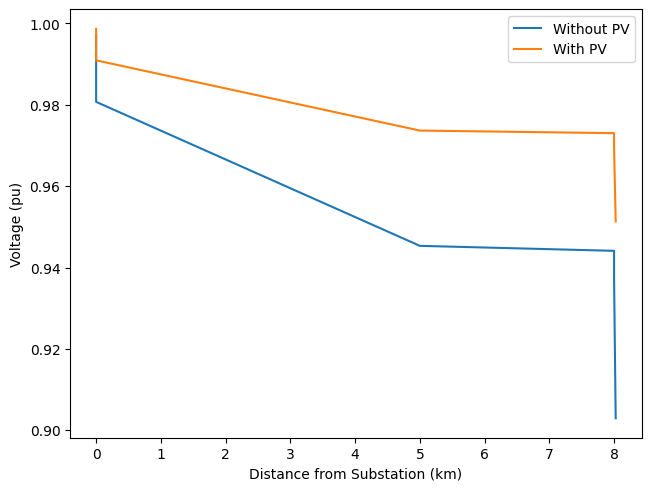

In [48]:
voltage_pu_solar=[]
for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    voltage_pu_solar.append(dss.Bus.PuVoltage()[0])

fig, ax=plt.subplots(layout='constrained')
ax.plot(distance,voltage_pu, label='Without PV')
ax.plot(distance, voltage_pu_solar, label='With PV')
ax.set_xlabel('Distance from Substation (km)')
ax.set_ylabel('Voltage (pu)')
ax.legend();

#### PV Load Analysis
Let's see how our PV affects feeder loading. Let's plot out both of our loadshapes and then the feeder-level P and Q with and without solar. 

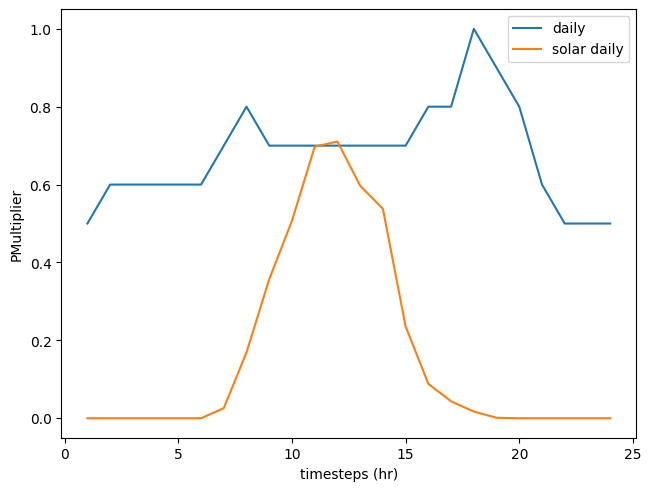

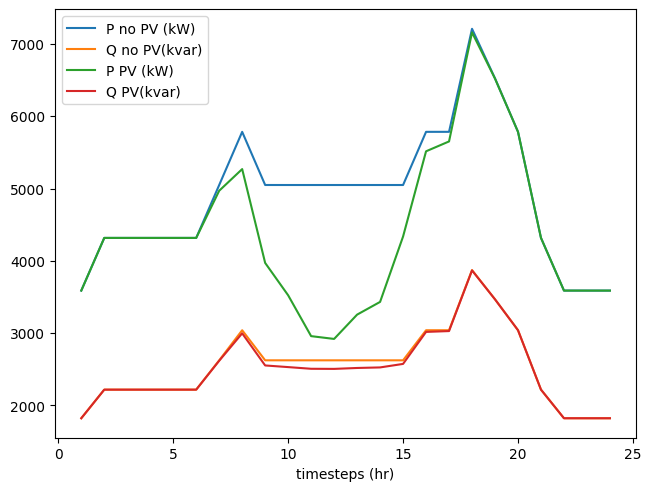

In [49]:

dss.LoadShape.Name('daily')
timesteps=range(1,dss.LoadShape.Npts()+1)
pmultiplier=dss.LoadShape.PMult()
dss.LoadShape.Name('solar_daily')
pvmultiplier=dss.LoadShape.PMult()

kw_solar=[]
kvar_solar=[]
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve() # the advancing happens here
    kw_solar.append(-dss.Circuit.TotalPower()[0])
    kvar_solar.append(-dss.Circuit.TotalPower()[1])

fig, ax=plt.subplots(layout='constrained')
ax.plot(timesteps,pmultiplier, label='daily')
ax.plot(timesteps,pvmultiplier, label='solar daily' )
ax.set_xlabel('timesteps (hr)')
ax.set_ylabel('PMultiplier')
ax.legend();

fig, ax=plt.subplots(layout='constrained')
ax.plot(timesteps,kw, label='P no PV (kW)')
ax.plot(timesteps,kvar, label='Q no PV(kvar)')
ax.plot(timesteps,kw_solar, label='P PV (kW)')
ax.plot(timesteps,kvar_solar, label='Q PV(kvar)')
ax.set_xlabel('timesteps (hr)')
ax.legend();

#### PV Bus Voltage Analysis
Let's visualize the range of voltages seen at each bus with and without PV.

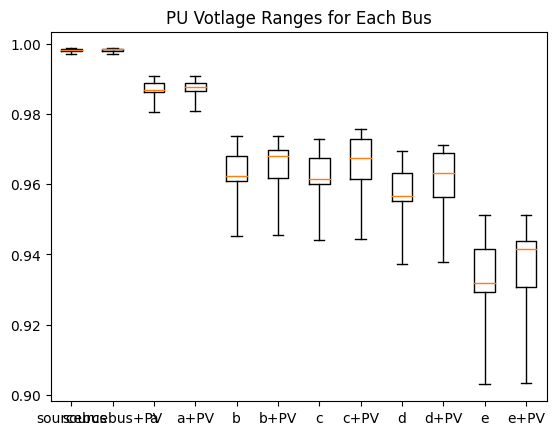

In [50]:
voltage_ts_solar={}

for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    voltage_ts_solar[bus]=[]
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()
        voltage_ts_solar[bus].append(dss.Bus.PuVoltage()[0])

combined_voltage_ts={}
for index, (key,value) in enumerate(voltage_ts.items()):
    combined_voltage_ts[key]=value
    combined_voltage_ts[str(key)+'+PV']=voltage_ts_solar[key]

fig1,ax1=plt.subplots()
ax1.set_title('PU Votlage Ranges for Each Bus')
ax1.boxplot([v for v in combined_voltage_ts.values()], labels= combined_voltage_ts.keys(), whis=[0,100]);

#### PV Loss Assessment
How does PV affect system losses and revenue?

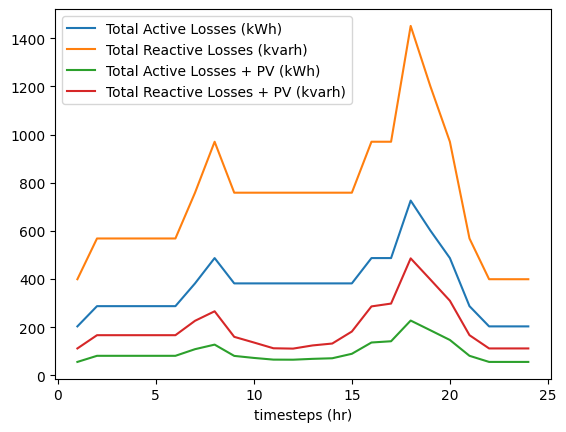

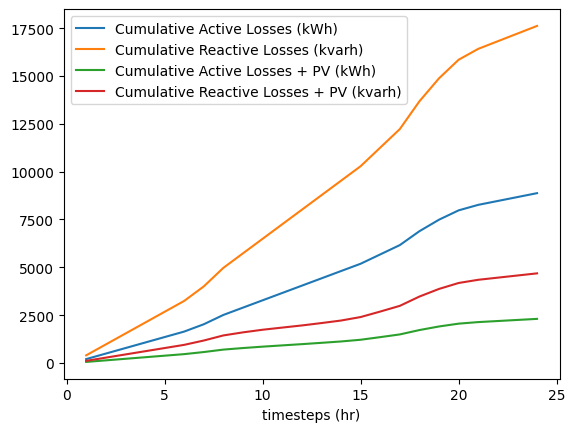

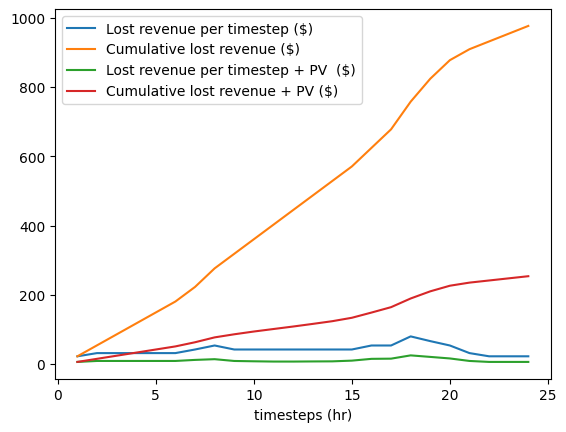

In [51]:
import numpy as np

active_losses_solar=[]
reactive_losses_solar=[]
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve()
    active_losses_solar.append(dss.Circuit.Losses()[0]/1000)
    reactive_losses_solar.append(dss.Circuit.Losses()[1]/1000)

cumulative_active_losses_solar=np.cumsum(np.asarray(active_losses_solar))
cumulative_reactive_losses_solar=np.cumsum(np.asarray(reactive_losses_solar))

price_kwh=0.11
lost_revenue_solar=np.asarray(active_losses_solar)*price_kwh
cumulative_lost_revenue_solar=np.cumsum(lost_revenue_solar)

fig,ax=plt.subplots()
ax.plot(timesteps, active_losses, label='Total Active Losses (kWh)')
ax.plot(timesteps, reactive_losses, label='Total Reactive Losses (kvarh)');
ax.plot(timesteps, active_losses_solar, label='Total Active Losses + PV (kWh)')
ax.plot(timesteps, reactive_losses_solar, label='Total Reactive Losses + PV (kvarh)');
ax.set_xlabel('timesteps (hr)')
ax.legend();

fig,ax=plt.subplots()
ax.plot(timesteps, cumulative_active_losses, label='Cumulative Active Losses (kWh)')
ax.plot(timesteps, cumulative_reactive_losses, label='Cumulative Reactive Losses (kvarh)')
ax.plot(timesteps, cumulative_active_losses_solar, label='Cumulative Active Losses + PV (kWh)')
ax.plot(timesteps, cumulative_reactive_losses_solar, label='Cumulative Reactive Losses + PV (kvarh)')
ax.set_xlabel('timesteps (hr)')
ax.legend();

fig1,ax1=plt.subplots()
ax1.plot(timesteps, lost_revenue, label='Lost revenue per timestep ($)')
ax1.plot(timesteps, cumulative_lost_revenue, label='Cumulative lost revenue ($)')
ax1.plot(timesteps, lost_revenue_solar, label='Lost revenue per timestep + PV  ($)')
ax1.plot(timesteps, cumulative_lost_revenue_solar, label='Cumulative lost revenue + PV ($)')
ax1.set_xlabel('timesteps (hr)')
ax1.legend();

#### What if a solar developer wants to know how much hosting capacity the feeder has, specifically on BusC where they have purchased land to build a solar farm. 
To answer this question, we can incrementally increase our pv system interconnecting to busC and check for violations at each step. 
In this very simple analysis we will check for three types of violations: overvoltage, conductor overload, and reverse powerflow at the substation. 
We will print out the first violation that occurs and at what pv size upgrades would be necessary. We can comment out certain checks if we don't want to evaluate for each of these three criteria. 

In [52]:
ov_threshold=1.05
dg_kva_increment=100

dg_kva_set=0.1
voltage_violation=False
line_overload=False
reverse_power_flow=False

while not voltage_violation and not line_overload and not reverse_power_flow:

    cmd('clear')
    cmd('redirect C:\\Users\\epohl\\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\Simple_example_timeseries.dss')
    cmd('new loadshape.solar_daily npts=24 interval=1.0 csvfile=C:\\Users\\epohl\\Desktop\\CIFF_Dehli_Presentation\\Git_repo\\ciff\\OpenDSS_model_files\\inputs_outputs_timeseries\\solar_daily.txt')
    cmd('new pvsystem.pv1 bus1=C phases=3 kv=33 kva={kva} irradiance=0.98 pmpp={pmpp} kvar=0 %cutin=0.05 %cutout=0.05 daily=solar_daily'.format(kva=dg_kva_set, pmpp=dg_kva_set))

    max_bus_voltage=False
    maxload_pct=False
    min_kw=False
    min_kvar=False

    #iterate through timesteps
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()

        #find max bus voltage for current timestep
        for bus in dss.Circuit.AllBusNames():
            dss.Circuit.SetActiveBus(bus)
            bus_voltage=dss.Bus.PuVoltage()[0]
            if not max_bus_voltage:
                max_bus_voltage=bus_voltage
                max_voltage_bus_name=bus
            elif bus_voltage>max_bus_voltage:
                max_bus_voltage=bus_voltage
                max_voltage_bus_name=bus
        
        #find max line loadings for current timestep
        dss.Lines.First()
        while True:
            line_load_pct=max(dss.CktElement.CurrentsMagAng()[0],dss.CktElement.CurrentsMagAng()[2], dss.CktElement.CurrentsMagAng()[4])/dss.Lines.NormAmps()
            if not maxload_pct:
                maxload_pct=line_load_pct/dss.Lines.NormAmps()
                maxload_line=dss.Lines.Name()
            elif line_load_pct>maxload_pct:
                maxload_pct=line_load_pct
                maxload_line=dss.Lines.Name()
            if not dss.Lines.Next() > 0:
                break

        #find total power flow at substion
        time_step_kw=-dss.Circuit.TotalPower()[0]
        time_step_kvar=-dss.Circuit.TotalPower()[1]
        if not min_kw:
            min_kw=time_step_kw
        elif time_step_kw<min_kw:
            min_kw=time_step_kw
        if not min_kvar:
            min_kvar=time_step_kvar
        elif time_step_kvar<min_kvar:
            min_kvar=time_step_kvar
            

    # run checks for current circuit. Comment out two checks to only evaluate one. 

    # line loading
    if maxload_pct>1:
        print('DG size = {dg}: \t Line overload at line section {name}, {loading}% normamps'.format(dg=dg_kva_set, name=maxload_line, loading=maxload_pct*100))
        line_overload=True

    # bus voltages
    if max_bus_voltage>ov_threshold:
        print('DG size = {dg}: \t Voltage violation at bus {name}, {bus_voltage} pu'.format(dg=dg_kva_set, name=max_voltage_bus_name, bus_voltage=max_bus_voltage))
        voltage_violation=True

    # reverse power flow
    if min_kvar < 0 or min_kw < 0:
        print('DG size = {dg}: \t Reverse power flow at the subsation, {kw} kw, {kvar} kvar'.format(dg=dg_kva_set, kw=min_kw, kvar=min_kvar))
        reverse_power_flow=True

    #increase solar system size by specified increment
    dg_kva_set+=dg_kva_increment



DG size = 7300.1: 	 Reverse power flow at the subsation, -41.87874531930445 kw, 1823.0708849292384 kvar
